In [0]:
#import nessecery libraries
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt
from torchvision import datasets,transforms,models
import torch.nn.functional as F
from torch import nn,optim
from torch.utils.data import Dataset, TensorDataset
from torch.optim import lr_scheduler
from torch.autograd import variable
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

In [3]:
#import data

import gdown 

gdown.download("https://drive.google.com/uc?id={0}".format("1taLeBecpTwYIziaHruXZzskfJv54-E2i"),"X.npy",quiet = False)

gdown.download("https://drive.google.com/uc?id={0}".format("1l2WMmcEccftsNsTT2cJ9490Q2zI-bvVb"),"Y.npy",quiet = False)

X = np.load('X.npy')
y = np.load('Y.npy')

#convert y to 1 rank matrix
Y = np.zeros(y.shape[0])


print(X.shape)
print(Y.shape)


Downloading...
From: https://drive.google.com/uc?id=1taLeBecpTwYIziaHruXZzskfJv54-E2i
To: /content/X.npy
33.8MB [00:00, 35.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1l2WMmcEccftsNsTT2cJ9490Q2zI-bvVb
To: /content/Y.npy
100%|██████████| 82.6k/82.6k [00:00<00:00, 16.7MB/s]

(2062, 64, 64)
(2062,)


In [0]:
#postion of each digit 
Y[:204]=0
Y[204:411]=1
Y[411:617]=2
Y[617:824]=3
Y[824:1030]=4
Y[1030:1237]=5
Y[1237:1444]=6
Y[1444:1650]=7
Y[1650:1858]=8
Y[1858:]=9

(-0.5, 63.5, 63.5, -0.5)

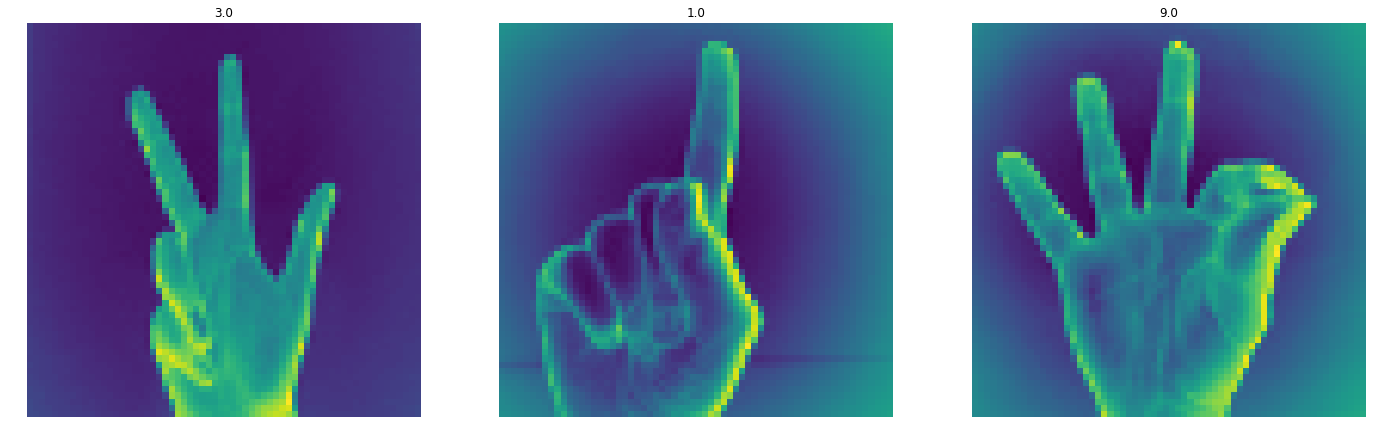

In [5]:
#check if the data (X ,Y) is aligned properly 

plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
plt.imshow(X[757])
plt.title((Y[757]))
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(X[403])
plt.title((Y[403]))
plt.axis("off")


plt.subplot(1,3,3)
plt.imshow(X[1900])
plt.title((Y[1900]))
plt.axis("off")

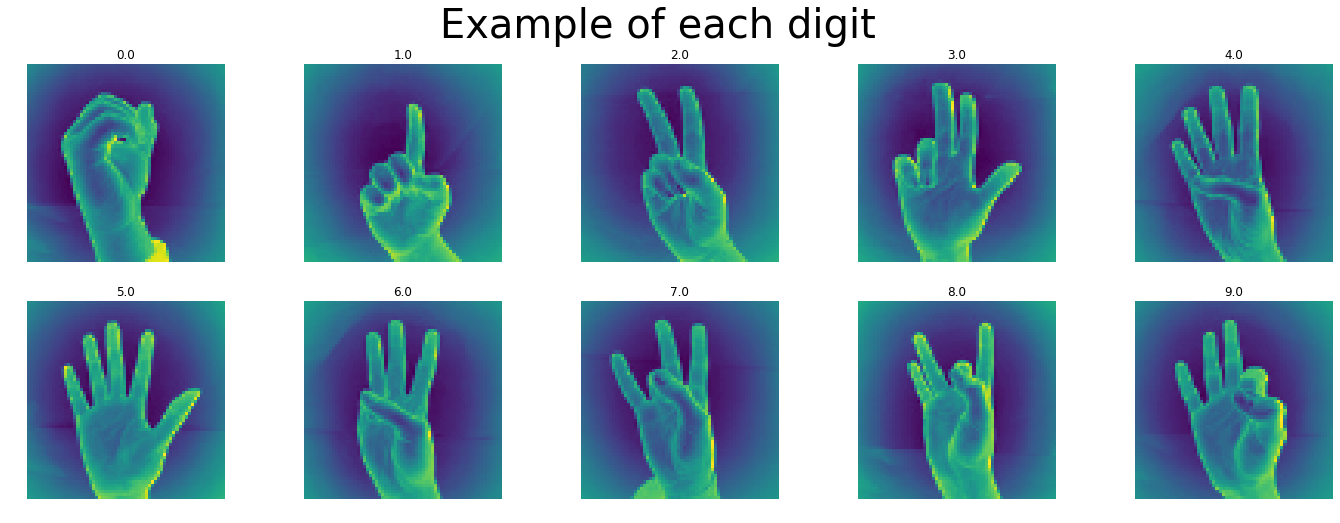

In [6]:
#present one sample of each digit


plt.figure(figsize=(24,8))
s=0
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.title(Y[s])
  plt.imshow(X[s])
  plt.axis("off")
  s+=207
  
plt.suptitle("Example of each digit", fontsize=40)
plt.show()

In [7]:

#create train and test data sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 42)


X_train.shape, y_train.shape, X_test.shape

((1649, 64, 64), (1649,), (413, 64, 64))

In [0]:
#split train data set to train and valid dataset
from sklearn.model_selection import train_test_split

Xf_train, X_valid, yf_train, y_valid = train_test_split(X_train, y_train, test_size = .2, random_state = 42)


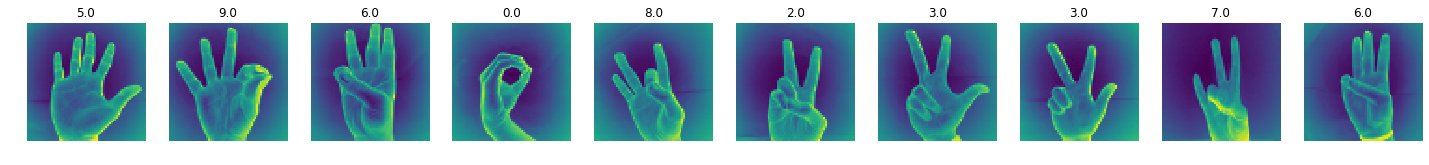

In [9]:
#exploring data after splitting 
plt.figure(figsize = (25, 8))
for num, i in enumerate(X_train[0:10]):
    plt.subplot(1,10,num+1)
    plt.axis('off')
    plt.imshow(i)
    plt.title(y_train[num])
    

In [0]:
#Data Augmentation

data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(25),
        transforms.RandomResizedCrop(200),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], 
                            [0.5])
]),
    
    'valid': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], 
                             [0.5])
    ]),
}

In [0]:
class DtProcessing(Dataset):
    
    #initialise the class variables - transform, data, target
    def __init__(self, data, target, transform=None): 
        self.transform = transform
        self.data = data.reshape((-1,64,64)).astype(np.float32)[:,:,:,None]
        # converting target to torch.LongTensor dtype
        self.target = torch.from_numpy(target).long() 
    
    #retrieve the X and y index value and return it
    def __getitem__(self, index): 
        return self.transform(self.data[index]), self.target[index]
    
    #returns the length of the data
    def __len__(self): 
        return len(list(self.data))

In [0]:

dset_train = DtProcessing(Xf_train, yf_train, data_transforms['train'])

train_loader = torch.utils.data.DataLoader(dset_train, batch_size=32,
                                          shuffle=True, num_workers=0)

dset_valid = DtProcessing(X_valid, y_valid, data_transforms['valid'])

valid_loader = torch.utils.data.DataLoader(dset_valid, batch_size=32,
                                          shuffle=True, num_workers=0)


dset_test = DtProcessing(X_test, y_test, data_transforms['valid'])
                                           
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=32,
                                          shuffle=True, num_workers=0)

torch.Size([32, 1, 200, 200])
torch.Size([32])


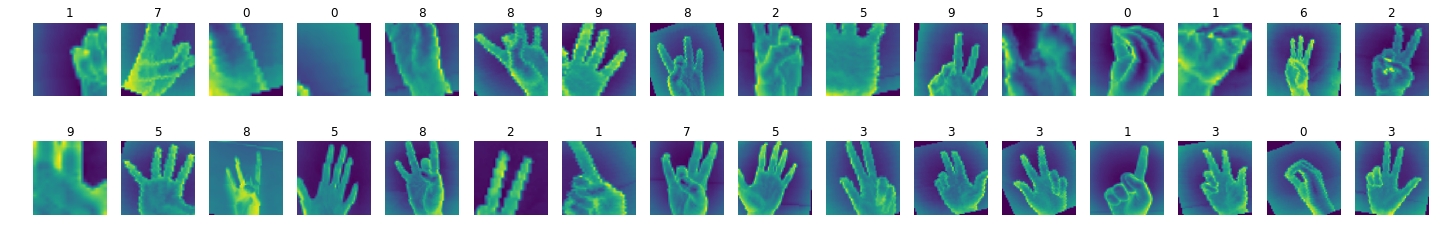

In [13]:

#visualization of Images  in one batch for train dataset

images,labels=next(iter(train_loader))

print(images.shape)
print(labels.shape)

plt.figure(figsize = (25,4))
for num in np.arange(images.size(0)):
    plt.subplot(2,(images.size(0))/2,num+1)
    plt.axis('off')
    plt.title(labels[num].numpy().squeeze())
    plt.imshow(images[num].numpy().squeeze())



torch.Size([32, 1, 224, 224])
torch.Size([32])


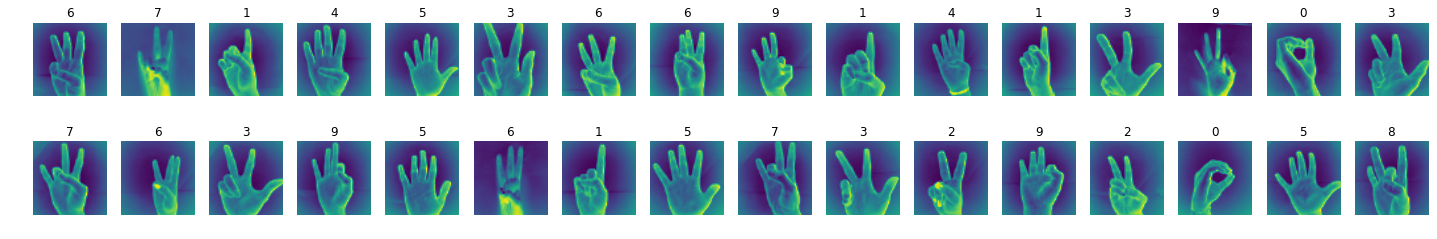

In [14]:

#visualization of Images in one batch for test dataset

images,labels=next(iter(test_loader))

print(images.shape)
print(labels.shape)

plt.figure(figsize = (25,4))
for num in np.arange(images.size(0)):
    plt.subplot(2,images.size(0)/2,num+1)
    plt.axis('off')
    plt.title(labels[num].numpy().squeeze())
    plt.imshow(images[num].numpy().squeeze())


In [0]:
#CNN Model


import torch.nn.functional as F


class Net(nn.Module):
  
  def __init__(self):
    
    super(Net,self).__init__()
    
    #input depth , output depth , kernel size(filter)x
    
    self.conv1=nn.Conv2d(1,16,kernel_size=(3, 3),padding=(1, 1),stride=(1, 1))
    
    self.conv2=nn.Conv2d(16,32,kernel_size=(3, 3),padding=(1, 1),stride=(1, 1))
    
    self.conv3=nn.Conv2d(32,64,kernel_size=(3, 3),padding=(1, 1),stride=(1, 1))
    
    #padding for last conv layer 
    self.adapt = nn.AdaptiveMaxPool2d((4,4))  
    
    #padding layer
    self.pool=nn.MaxPool2d(2,2)
    
    #dropout layer
    self.drop=nn.Dropout(p=0.2)
    
    #fc layers 
    self.fc1=nn.Linear(64*4*4,512)
    
    self.fc2=nn.Linear(512,256)
    self.fc3=nn.Linear(256,128)
    self.fc4=nn.Linear(128,10)
    
  def forward(self,x):
    
    x=self.pool(F.leaky_relu(self.conv1(x)))
    
    x=self.pool(F.leaky_relu(self.conv2(x)))
    
    x=self.adapt(F.leaky_relu(self.conv3(x)))
    
    
    #flatten Images
    x = x.view(x.size(0), -1)
    
    x=self.drop(x)
    
    x=F.leaky_relu(self.fc1(x))
    
    x=self.drop(x)
    x=F.leaky_relu(self.fc2(x))
    
    x=self.drop(x)
    x=F.leaky_relu(self.fc3(x))
    
    x=self.drop(x)
    
    x=self.fc4(x)
    
    return F.log_softmax(x) 
      
     

In [26]:

model = Net()
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adapt): AdaptiveMaxPool2d(output_size=(4, 4))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [0]:
def train(n_epochs=100):
  
  valid_loss_min = np.Inf # track change in validation loss

  for epoch in range(1, n_epochs+1):
    

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
   #train
    model.train()
    for data, target in train_loader:
        
        
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    #validate
    model.eval()
    accuracy=0.0
    for data, target in valid_loader:
        
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
        ps=torch.exp(output)
               
        top_p,top_class=ps.topk(1,dim=1)
        equals=top_class==target.view(*top_class.shape)
        accuracy+=torch.mean(equals.type(torch.FloatTensor))
    
    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \t Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss,accuracy/len(valid_loader)))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print("==============================================================================================")
        print('Validation loss decreased ({:.6f} --> {:.6f}). \tBest train Accuracy: {:.6f} >>>>>>>  Saving model ...'.format(
        valid_loss_min,
        valid_loss,accuracy/len(valid_loader)))
        print("==============================================================================================")
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

In [28]:
train(150)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 72.404310 	Validation Loss: 69.232357 	 Accuracy: 0.085795
Validation loss decreased (inf --> 69.232357). 	Best train Accuracy: 0.085795 >>>>>>>  Saving model ...
Epoch: 2 	Training Loss: 72.162888 	Validation Loss: 67.709193 	 Accuracy: 0.130682
Validation loss decreased (69.232357 --> 67.709193). 	Best train Accuracy: 0.130682 >>>>>>>  Saving model ...
Epoch: 3 	Training Loss: 71.014557 	Validation Loss: 64.708080 	 Accuracy: 0.277273
Validation loss decreased (67.709193 --> 64.708080). 	Best train Accuracy: 0.277273 >>>>>>>  Saving model ...
Epoch: 4 	Training Loss: 68.913943 	Validation Loss: 62.014997 	 Accuracy: 0.346591
Validation loss decreased (64.708080 --> 62.014997). 	Best train Accuracy: 0.346591 >>>>>>>  Saving model ...
Epoch: 5 	Training Loss: 67.243794 	Validation Loss: 56.082201 	 Accuracy: 0.339773
Validation loss decreased (62.014997 --> 56.082201). 	Best train Accuracy: 0.339773 >>>>>>>  Saving model ...
Epoch: 6 	Training Loss: 64.526021 	

In [0]:
model.load_state_dict(torch.load('model.pt'))

classes=['0','1','2','3','4','5','6','7','8','9']

In [0]:
def Cal_accurac():
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()
# iterate over test data
  for data, target in test_loader:
    
    batch_size = data.size(0)
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
  test_loss = test_loss/len(test_loader)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [32]:
Cal_accurac()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 4.575007

Test Accuracy of     0: 100% (40/40)
Test Accuracy of     1: 100% (48/48)
Test Accuracy of     2: 98% (49/50)
Test Accuracy of     3: 97% (34/35)
Test Accuracy of     4: 90% (29/32)
Test Accuracy of     5: 100% (38/38)
Test Accuracy of     6: 100% (41/41)
Test Accuracy of     7: 89% (34/38)
Test Accuracy of     8: 93% (42/45)
Test Accuracy of     9: 89% (41/46)

Test Accuracy (Overall): 95% (396/413)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range f

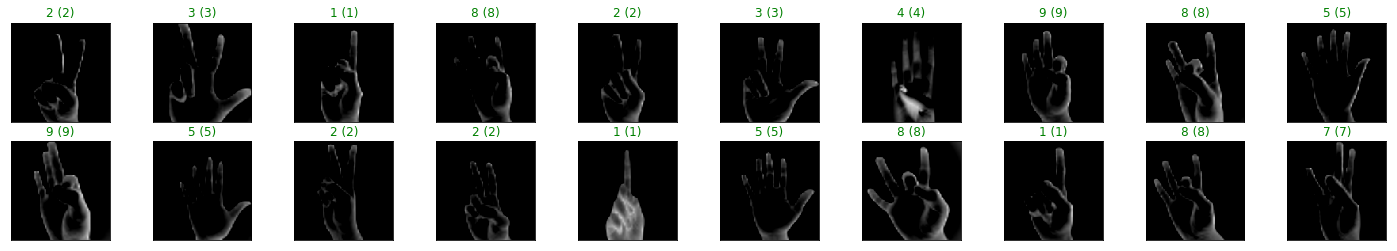

In [33]:
#obtain one batch of test images
images, labels = next(iter(test_loader))

images.numpy()

# move model inputs to cuda, if GPU available
if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(torchvision.utils.make_grid(images[idx], nrow=5).permute(1, 2, 0).cpu(),cmap='gray_r')

    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model_save_name = 'model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)